In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/youlee/n24news/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'

categories = [
    "Opinion", "Art & Design", "Television", "Music", "Travel",
    "Real Estate", "Books", "Theater", "Health", "Sports",
    "Science", "Food", "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]

data = pd.read_csv(file_path)
filtered_data = data[data['Label'].isin(categories)]

label_groups = [categories[i:i + 3] for i in range(0, len(categories), 3)]
group_files = []
for i, group in enumerate(label_groups, start=1):
    group_data = filtered_data[filtered_data['Label'].isin(group)]
    output_file_path = f'/home/youlee/n24news/n24news/group_{i}.csv'
    group_data.to_csv(output_file_path, index=False)
    group_files.append(output_file_path)

print("Grouped data files saved:")
for file in group_files:
    print(file)

Grouped data files saved:
/home/youlee/n24news/n24news/group_1.csv
/home/youlee/n24news/n24news/group_2.csv
/home/youlee/n24news/n24news/group_3.csv
/home/youlee/n24news/n24news/group_4.csv
/home/youlee/n24news/n24news/group_5.csv
/home/youlee/n24news/n24news/group_6.csv


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids, attention_masks = [], []
    
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [10]:
class PerceiverBlock(nn.Module):
    """
    - 크로스 어텐션 (latents -> x)
    - 이어서 셀프 어텐션 (latent들끼리)
    - 보통은 LayerNorm, MLP(FeedForward) 등을 곁들여 잔차 연결(residual branch)을 구성
    """
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        # 크로스 어텐션
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

        # 여러 층의 셀프 어텐션
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태로 가정
        # Perceiver 원리상 latents는 query, x는 key/value

        # 1) 크로스 어텐션
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents        # 잔차 연결
        latents = self.cross_ln(latents)           # LayerNorm

        # 2) 셀프 어텐션 반복
        for layer in self.self_attn_layers:
            latents = layer(latents)  # 내부적으로 잔차 연결 및 LayerNorm 포함

        return latents

class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        # 여러 개의 PerceiverBlock을 쌓음
        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
        """
        B, T, F = x.size()
        x = self.input_projection(x)                 # (B, T, latent_dim)

        # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
        x = x.permute(1, 0, 2)        # (T, B, latent_dim)
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

        # PerceiverBlock을 여러 번 반복
        for block in self.blocks:
            latents = block(latents, x)

        # 최종 latents: (latent_size, B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
        return self.output_layer(latents)
    
class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
        return self.perceiver(embeddings)       # Perceiver에 전달

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  # 현재 코드에서는 사용되지 않음
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  # 현재 코드에서는 사용되지 않음
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [13]:
EPOCHS = 10
BATCH_SIZE = 32
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
NUM_HEADS = 8
NUM_LAYERS = 4
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 6    # PerceiverBlock의 수

In [14]:
all_learning_curves = []

for idx, group_file in enumerate(group_files, start=1):
    print(f"\nProcessing Group {idx}...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Perceiver 모델 초기화
    perceiver = Perceiver(
        input_dim=EMBED_DIM,
        latent_dim=LATENT_DIM,
        latent_size=LATENT_SIZE,
        num_classes=num_classes,
        num_blocks=NUM_BLOCKS,
        self_attn_layers_per_block=1
    )

    # CombinedModel 초기화 (임베딩 포함)
    model = CombinedModel(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        perceiver_model=perceiver
    )
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)


    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'  Group {idx} Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'                             Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


    all_learning_curves.append({
        "Group": idx,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    })


    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device) 
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())


    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    results.append({
        "Group": idx,
        "Test Accuracy": test_acc,
        "Confusion Matrix": cm,
        "Classification Report": report
    })


Processing Group 1...
  Group 1 Epoch 1/10: Train Loss: 1.0451, Train Acc: 0.4380
                             Test Loss: 0.9790, Test Acc: 0.4863
  Group 1 Epoch 2/10: Train Loss: 0.8779, Train Acc: 0.5814
                             Test Loss: 0.8332, Test Acc: 0.6255
  Group 1 Epoch 3/10: Train Loss: 0.7893, Train Acc: 0.6507
                             Test Loss: 0.7549, Test Acc: 0.6584
  Group 1 Epoch 4/10: Train Loss: 0.7326, Train Acc: 0.6902
                             Test Loss: 0.6818, Test Acc: 0.7064
  Group 1 Epoch 5/10: Train Loss: 0.6350, Train Acc: 0.7476
                             Test Loss: 0.6144, Test Acc: 0.7661
  Group 1 Epoch 6/10: Train Loss: 0.5665, Train Acc: 0.7844
                             Test Loss: 0.6114, Test Acc: 0.7695
  Group 1 Epoch 7/10: Train Loss: 0.5192, Train Acc: 0.8037
                             Test Loss: 0.5321, Test Acc: 0.8011
  Group 1 Epoch 8/10: Train Loss: 0.4644, Train Acc: 0.8296
                             Test Loss: 0.

In [15]:
for result in results:
    print(f"\nGroup {result['Group']} Results:")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print(pd.DataFrame(result['Classification Report']).transpose())


Group 1 Results:
Test Accuracy: 0.8436
              precision    recall  f1-score      support
0              0.856180  0.783951  0.818475   486.000000
1              0.810409  0.904564  0.854902   482.000000
2              0.869474  0.842857  0.855959   490.000000
accuracy       0.843621  0.843621  0.843621     0.843621
macro avg      0.845354  0.843791  0.843112  1458.000000
weighted avg   0.845516  0.843621  0.843115  1458.000000

Group 2 Results:
Test Accuracy: 0.7674
              precision    recall  f1-score      support
0              0.891358  0.738241  0.807606   489.000000
1              0.792411  0.744235  0.767568   477.000000
2              0.664430  0.819876  0.734013   483.000000
accuracy       0.767426  0.767426  0.767426     0.767426
macro avg      0.782733  0.767451  0.769729  1449.000000
weighted avg   0.783142  0.767426  0.769895  1449.000000

Group 3 Results:
Test Accuracy: 0.8575
              precision    recall  f1-score      support
0              0.796407  

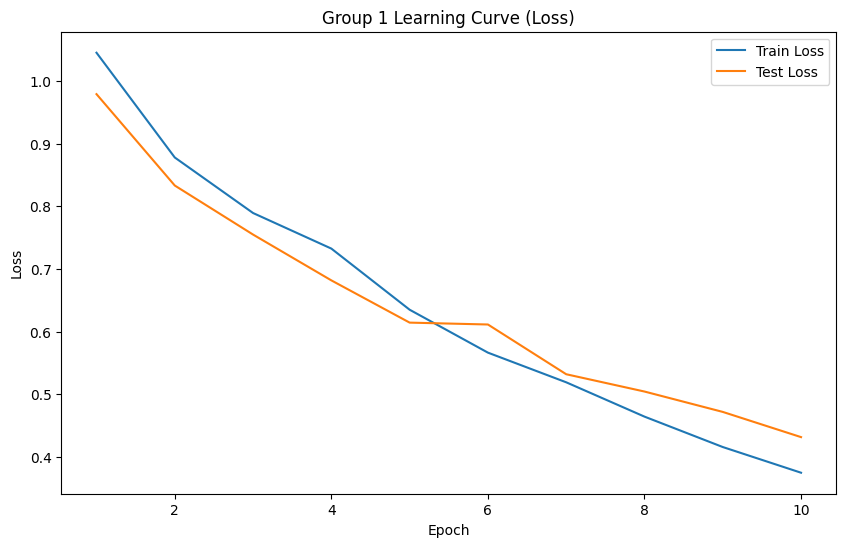

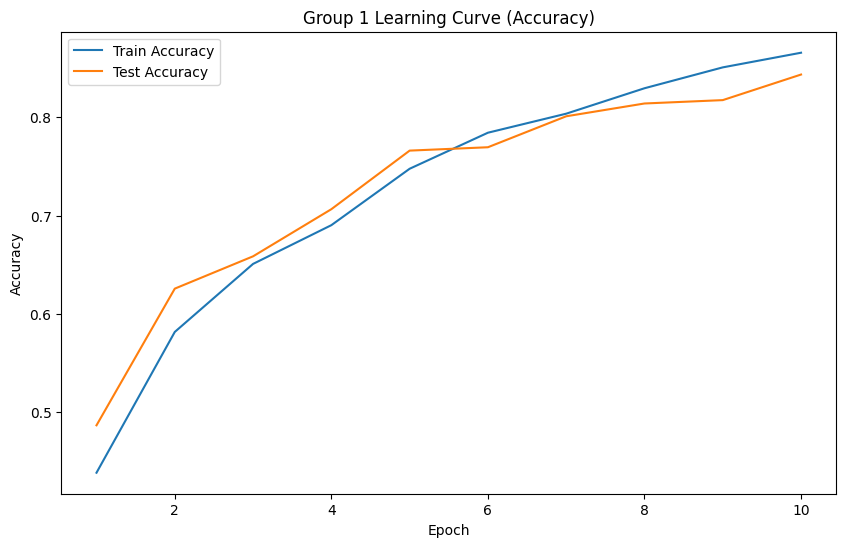

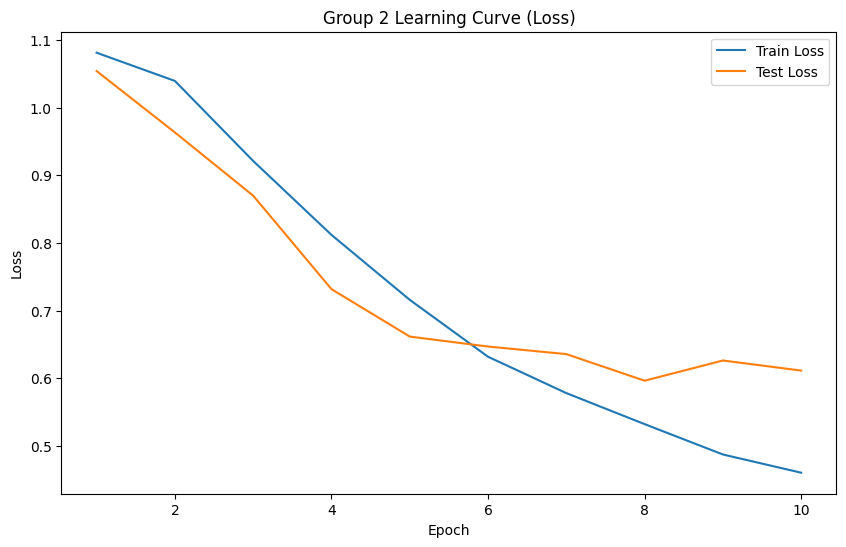

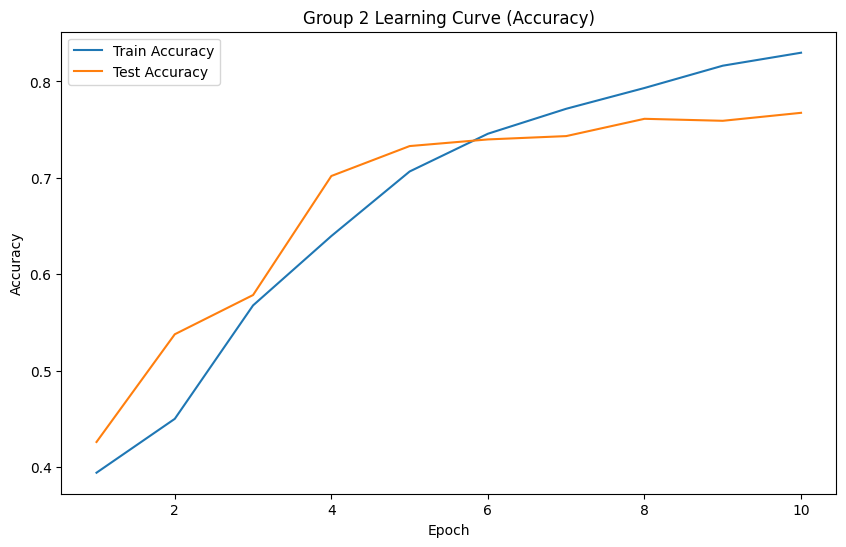

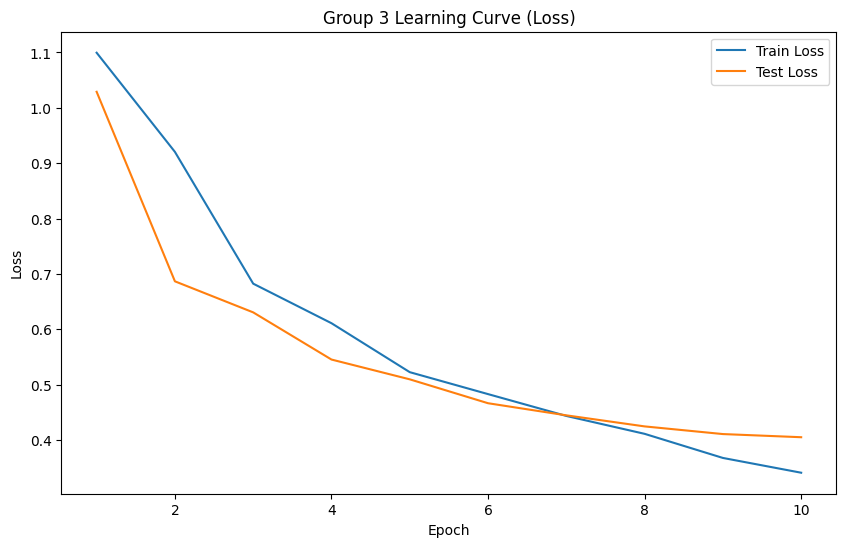

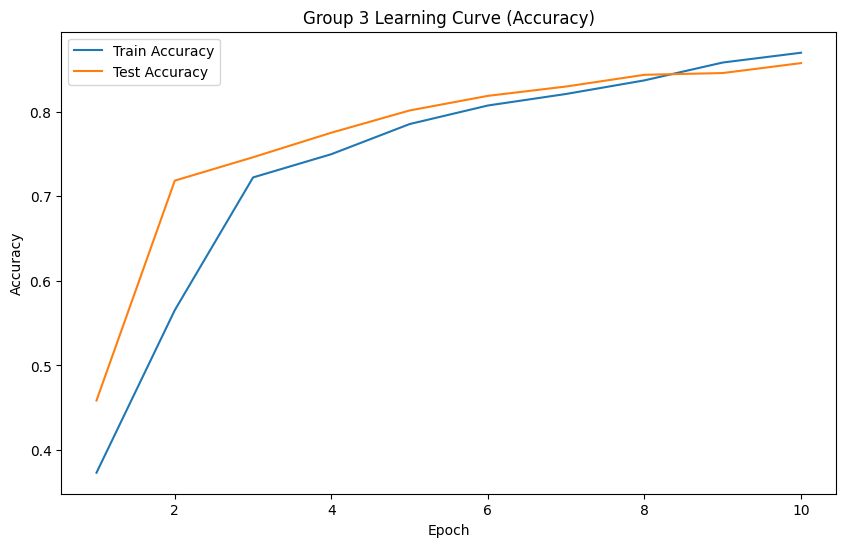

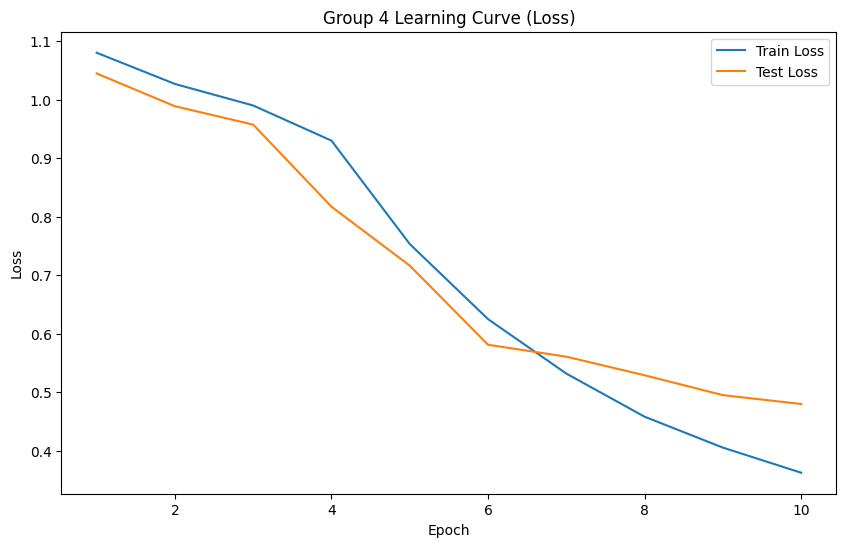

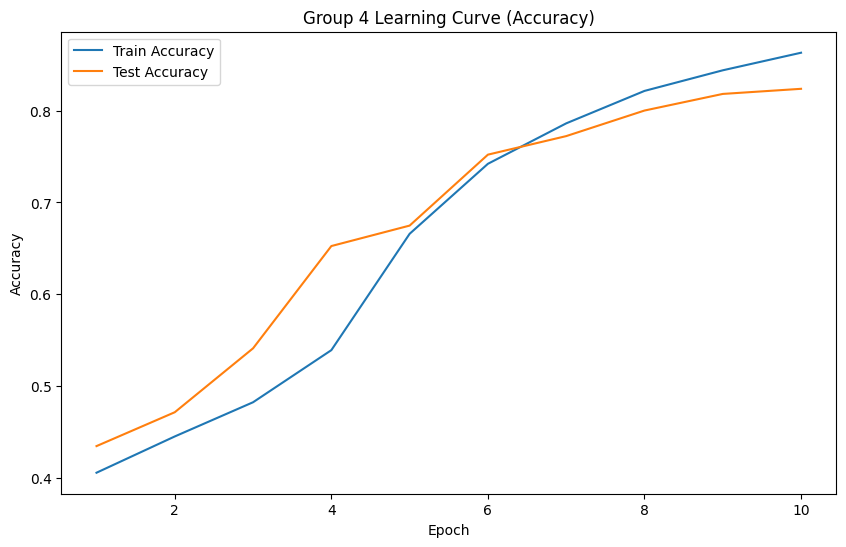

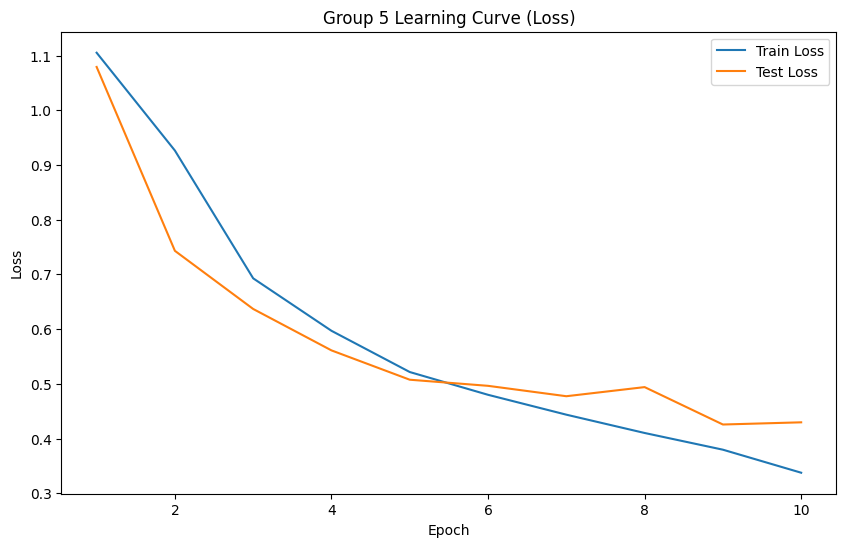

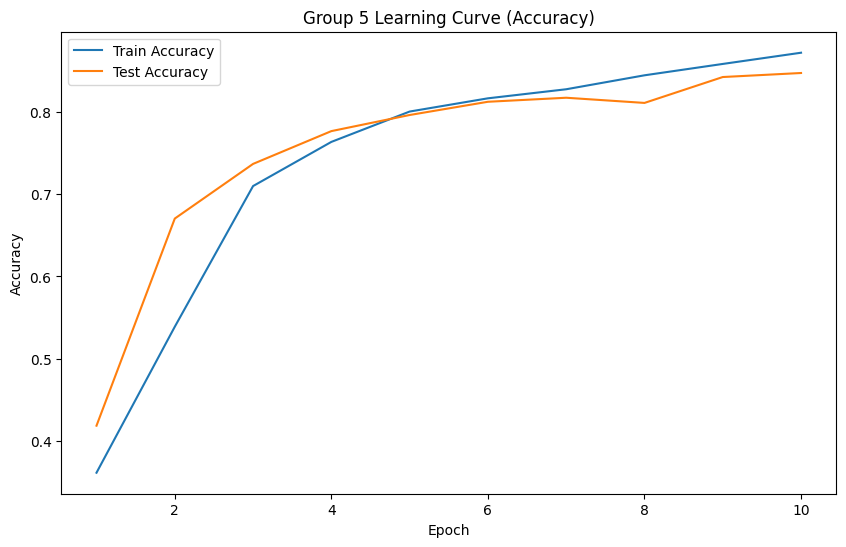

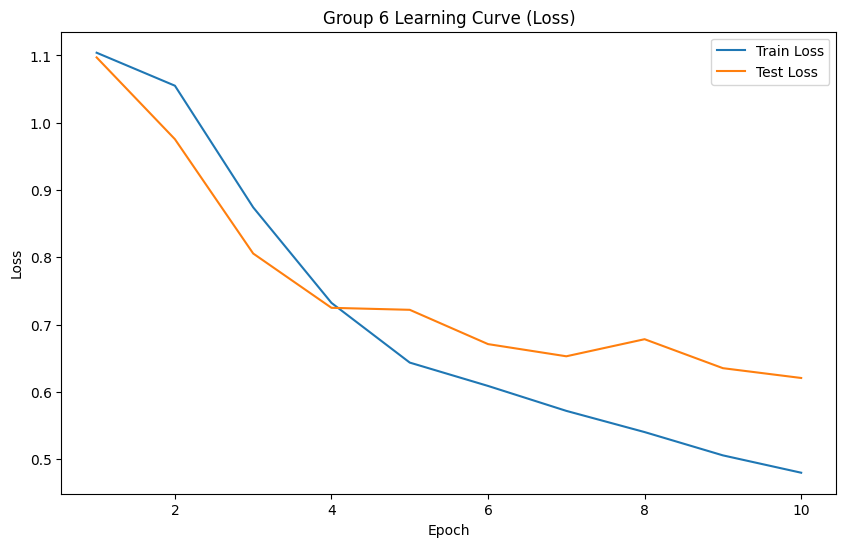

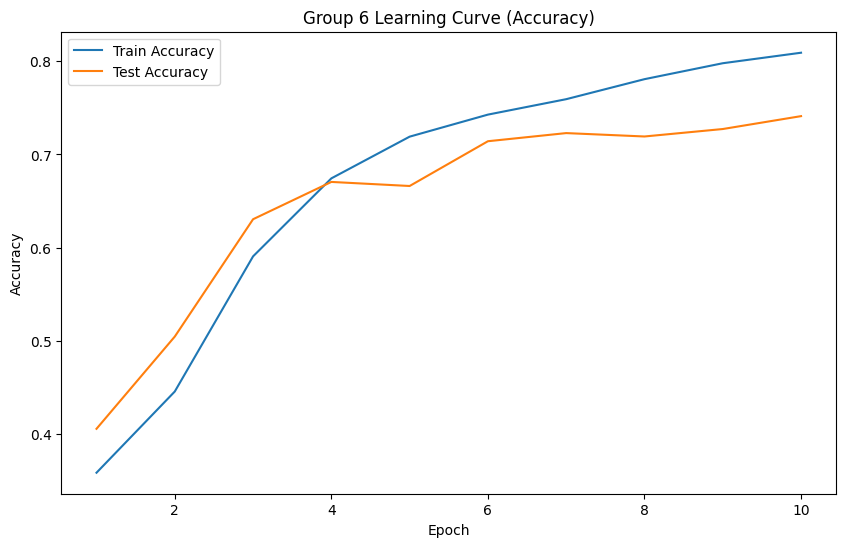

In [16]:
for curve in all_learning_curves:
    group_idx = curve["Group"]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="Test Loss")
    plt.title(f"Group {group_idx} Learning Curve (Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="Train Accuracy")
    plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="Test Accuracy")
    plt.title(f"Group {group_idx} Learning Curve (Accuracy)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


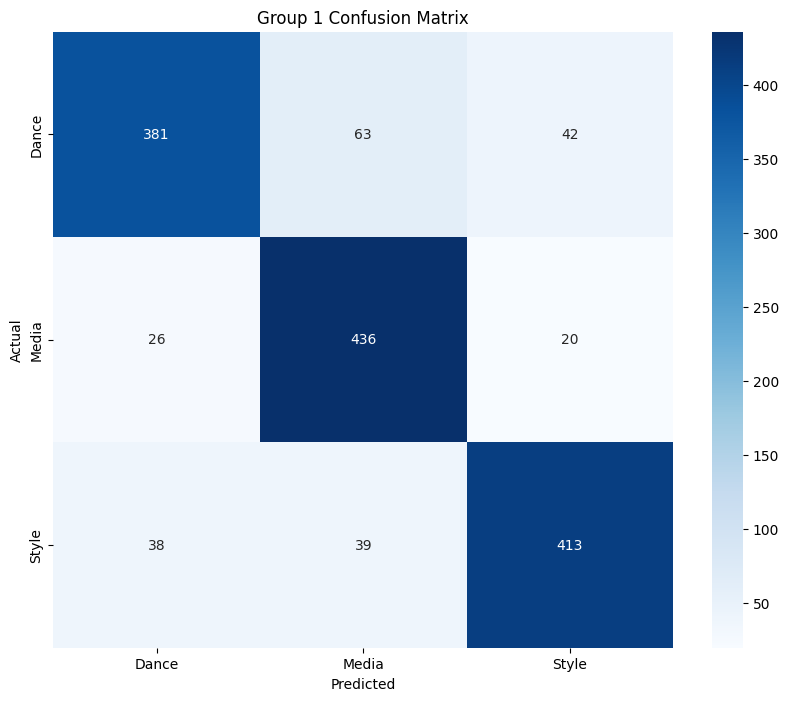

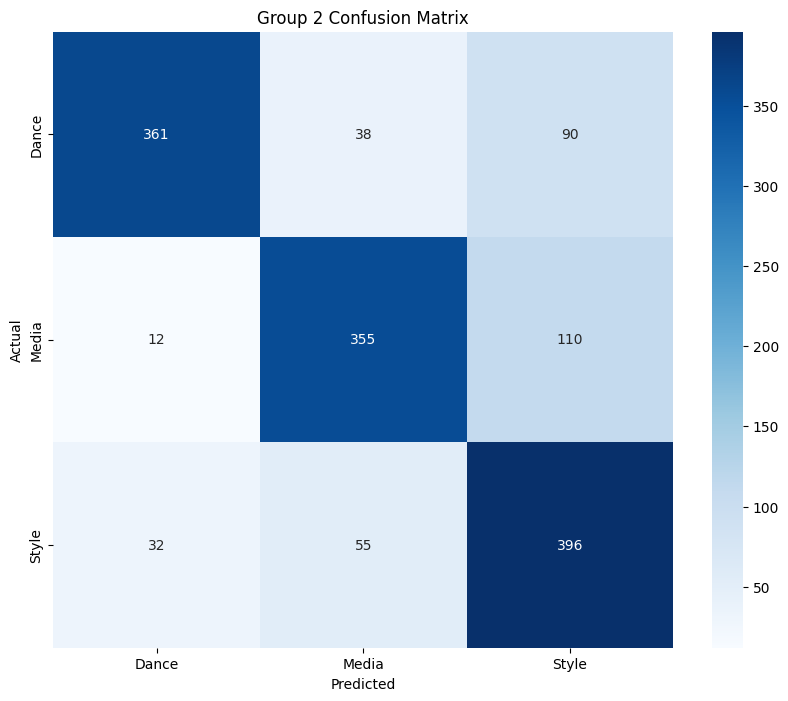

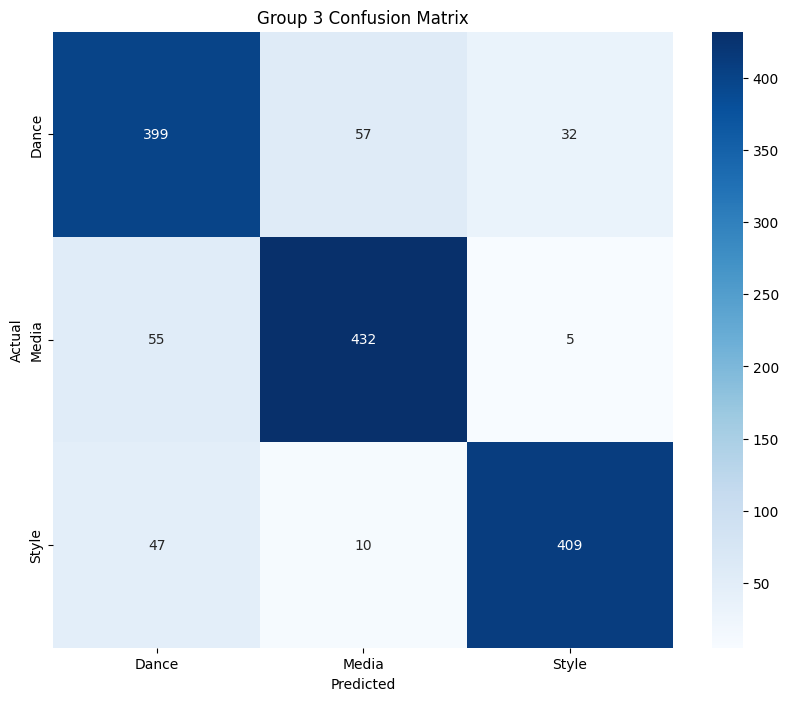

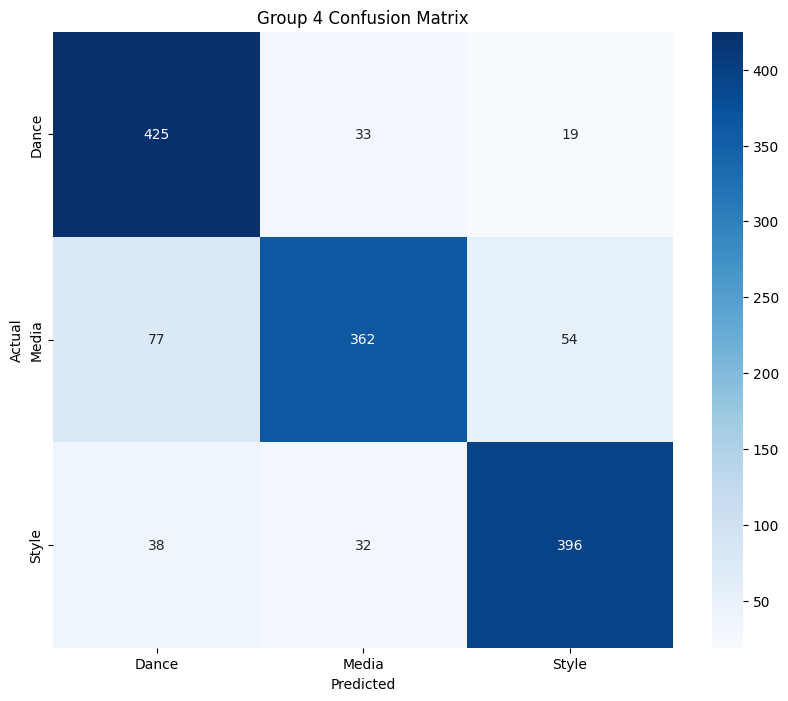

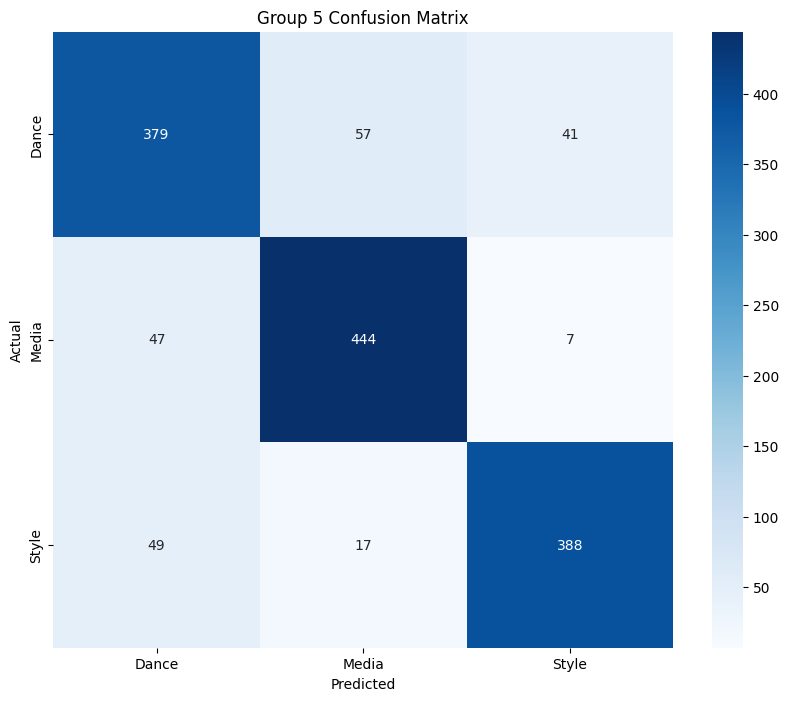

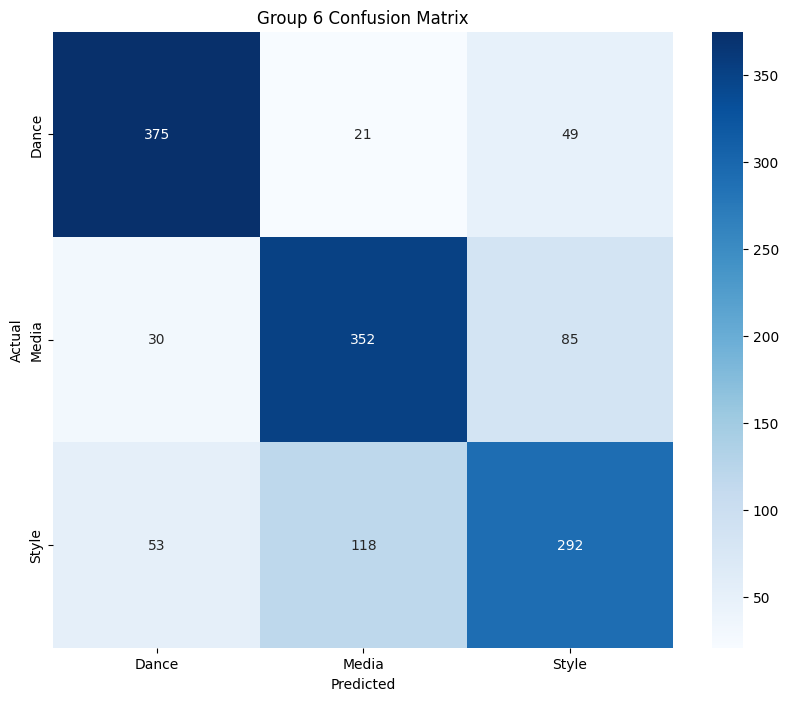

In [17]:
for result in results:
    group_idx = result["Group"]
    cm = result["Confusion Matrix"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f"Group {group_idx} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()